In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import models
import numpy as np
import pymc as pm
import seaborn as sns

sns.set_theme('notebook', 'ticks', 'colorblind')
sns_histplot_args = dict(stat='density', element='step', fill=False)

Here we define a Gaussian beam with a fixed opening angle and choose the expected counts so that we have $\sim 5 \sigma$ detections when face-on at the EM horizon.

In [3]:
opening_angle = 15 * np.pi / 180 # 15 degrees
dx_opening_angle = 1 - np.cos(opening_angle)
d_em_horiz = 0.2
scatter = 1.0 * np.log(10) # 1.0 dex scatter
def F_ex(x, d, scatter=True):
    L0 = 25.0*np.exp(-0.5*np.square(np.abs(x)-1)/np.square(dx_opening_angle))*d_em_horiz*d_em_horiz/(d*d)
    if scatter:
        return np.random.lognormal(mean=np.log(L0), sigma=scatter)
    else:
        return L0

Here we will analyze 128 events:

In [4]:
hmin = 0.35
hmax = 1.4
nobs = 128
em_detected, x_true, d_true, z_true, Al_true, Ar_true, Al, Ar, Ndraw = models.draw_gws(F_ex, 32768)

d_max_em_detected = np.max(z_true[em_detected])/hmin

assert nobs < np.sum(em_detected)

100%|██████████████████████████████████| 32768/32768 [00:02<00:00, 11103.90it/s]


The GW horizon seems to be somewhere around 0.3:

Text(0.5, 1.0, 'GW Detections')

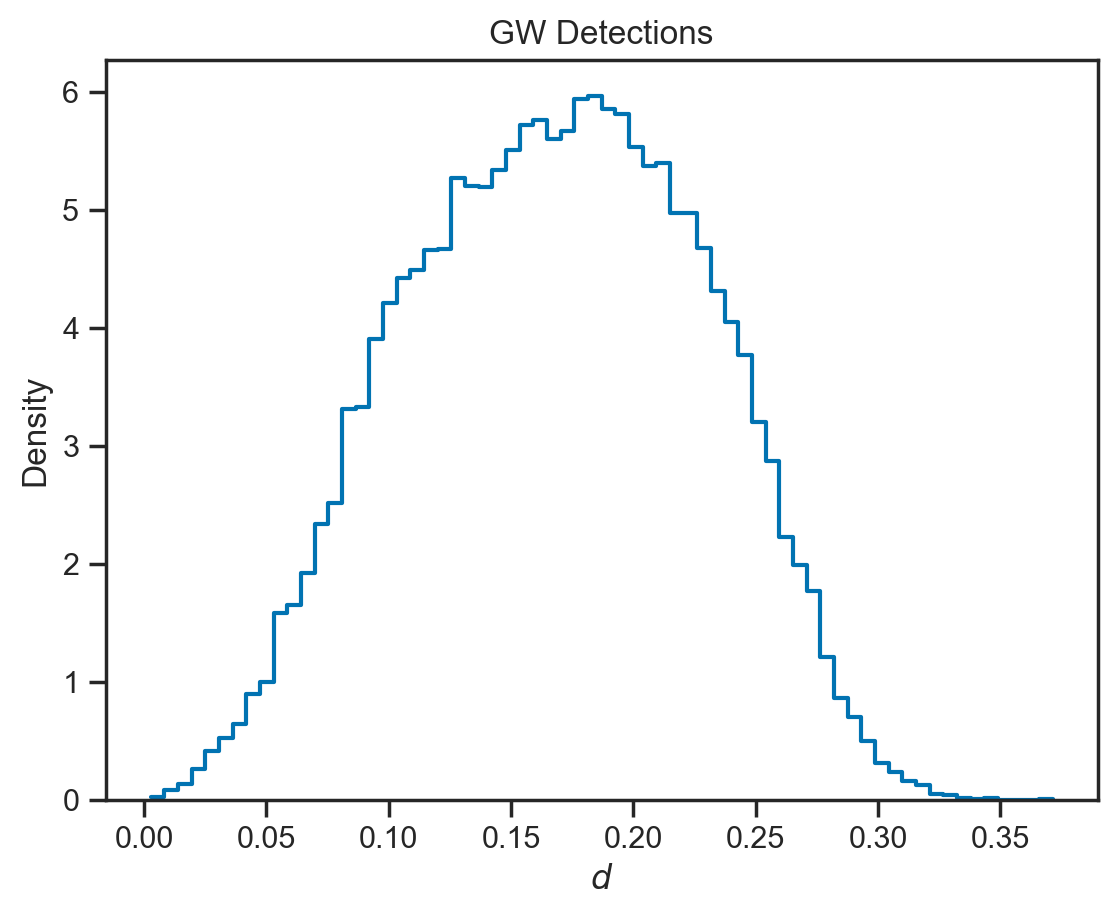

In [6]:
sns.histplot(d_true, **sns_histplot_args)
plt.xlabel(r'$d$')
plt.title('GW Detections')

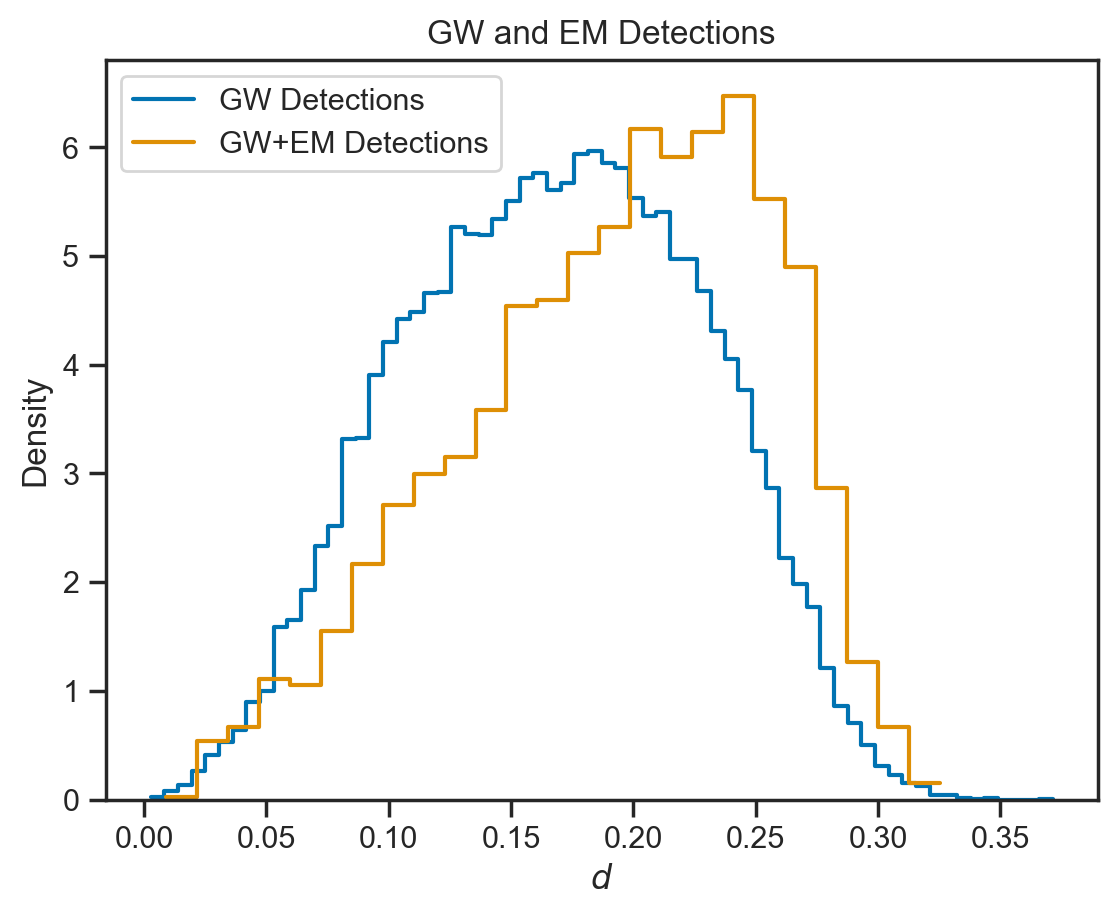

In [7]:
sns.histplot(d_true, label='GW Detections', **sns_histplot_args)
sns.histplot([d for (d, e) in zip(d_true, em_detected) if e], label='GW+EM Detections', **sns_histplot_args)
plt.xlabel(r'$d$')
plt.title('GW and EM Detections')
plt.legend()

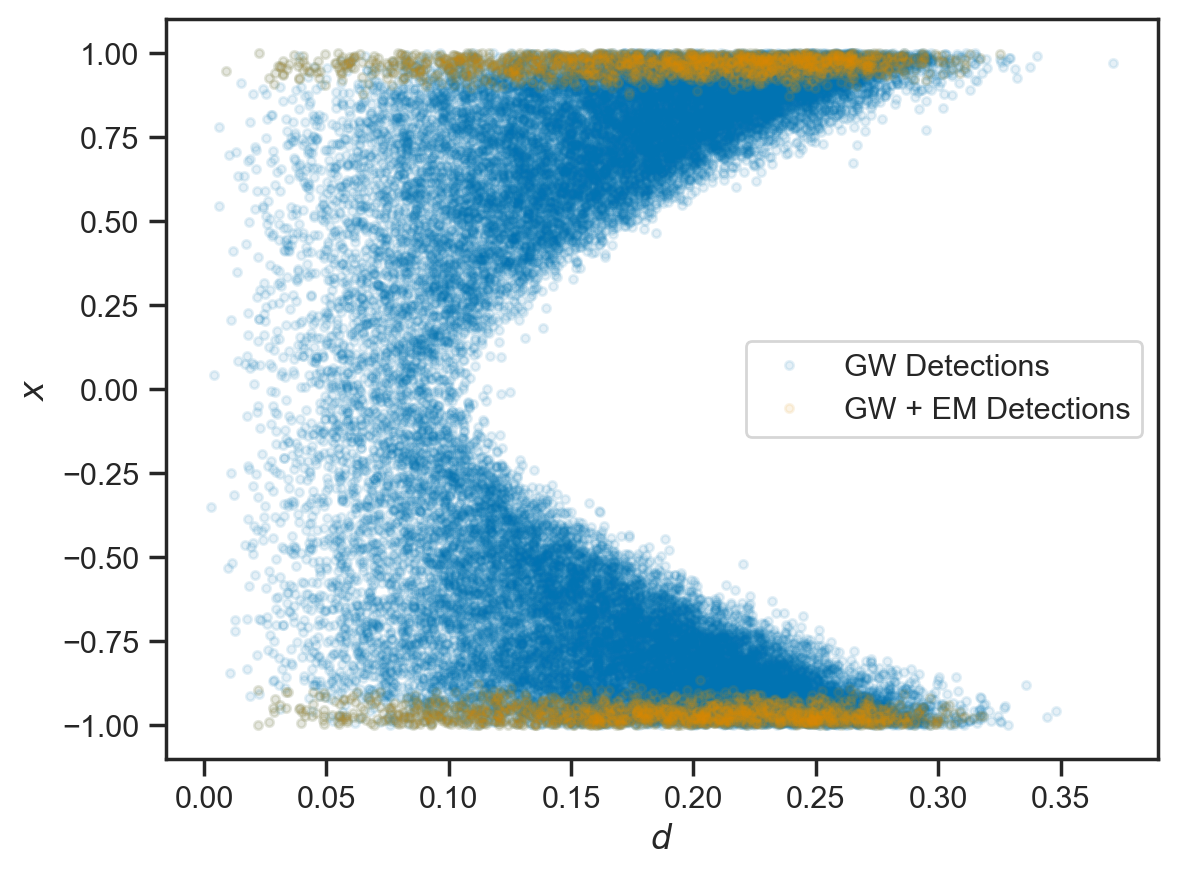

In [8]:
plt.plot(d_true, x_true, '.', label='GW Detections', alpha=0.1)
plt.plot([d for (d,e) in zip(d_true, em_detected) if e],
         [x for (x,e) in zip(x_true, em_detected) if e],
         '.',
         label='GW + EM Detections',
         alpha=0.1)
plt.xlabel(r'$d$')
plt.ylabel(r'$x$')
plt.legend()

First, we will run the model on the GW-selected events *as if* we had a redshift for every one:

In [9]:
model_gw_only = models.make_model(Al[:nobs], Ar[:nobs], z_true[:nobs], x_true, d_true, Ndraw, hmin=hmin, hmax=hmax)

In [10]:
with model_gw_only:
    trace_gw_only = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [11]:
az.summary(trace_gw_only)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
h         0.695  0.006   0.684    0.707      0.000    0.000     925.0   
x[0]     -0.909  0.052  -1.000   -0.823      0.001    0.001    2891.0   
x[1]     -0.678  0.048  -0.771   -0.592      0.001    0.000    8387.0   
x[2]     -0.254  0.040  -0.331   -0.180      0.000    0.000    7831.0   
x[3]      0.592  0.031   0.531    0.648      0.000    0.000    4782.0   
...         ...    ...     ...      ...        ...      ...       ...   
Ar[123]  17.940  0.973  16.218   19.852      0.015    0.011    4162.0   
Ar[124]   0.084  0.071   0.000    0.209      0.001    0.001    3229.0   
Ar[125]   0.019  0.025   0.000    0.063      0.000    0.000    2722.0   
Ar[126]   0.126  0.085   0.000    0.277      0.001    0.001    3510.0   
Ar[127]  11.537  0.712  10.209   12.854      0.009    0.006    6732.0   

         ess_tail  r_hat  
h          1798.0    1.0  
x[0]       1523.0    1.0  
x[1]       2330.0    1.0  
x[2]       2552.0    1.0  
x[3]       3035.0    1.0  
...           ...    ...  
Ar[123]    1473.0    1.0  
Ar[124]    1630.0    1.0  
Ar[125]    1450.0    1.0  
Ar[126]    1366.0    1.0  
Ar[127]    3096.0    1.0  

[513 rows x 9 columns]

array([[<Axes: title={'center': 'h'}>, <Axes: title={'center': 'h'}>],
       [<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>],
       [<Axes: title={'center': 'd'}>, <Axes: title={'center': 'd'}>],
       [<Axes: title={'center': 'Al'}>, <Axes: title={'center': 'Al'}>],
       [<Axes: title={'center': 'Ar'}>, <Axes: title={'center': 'Ar'}>]],
      dtype=object)

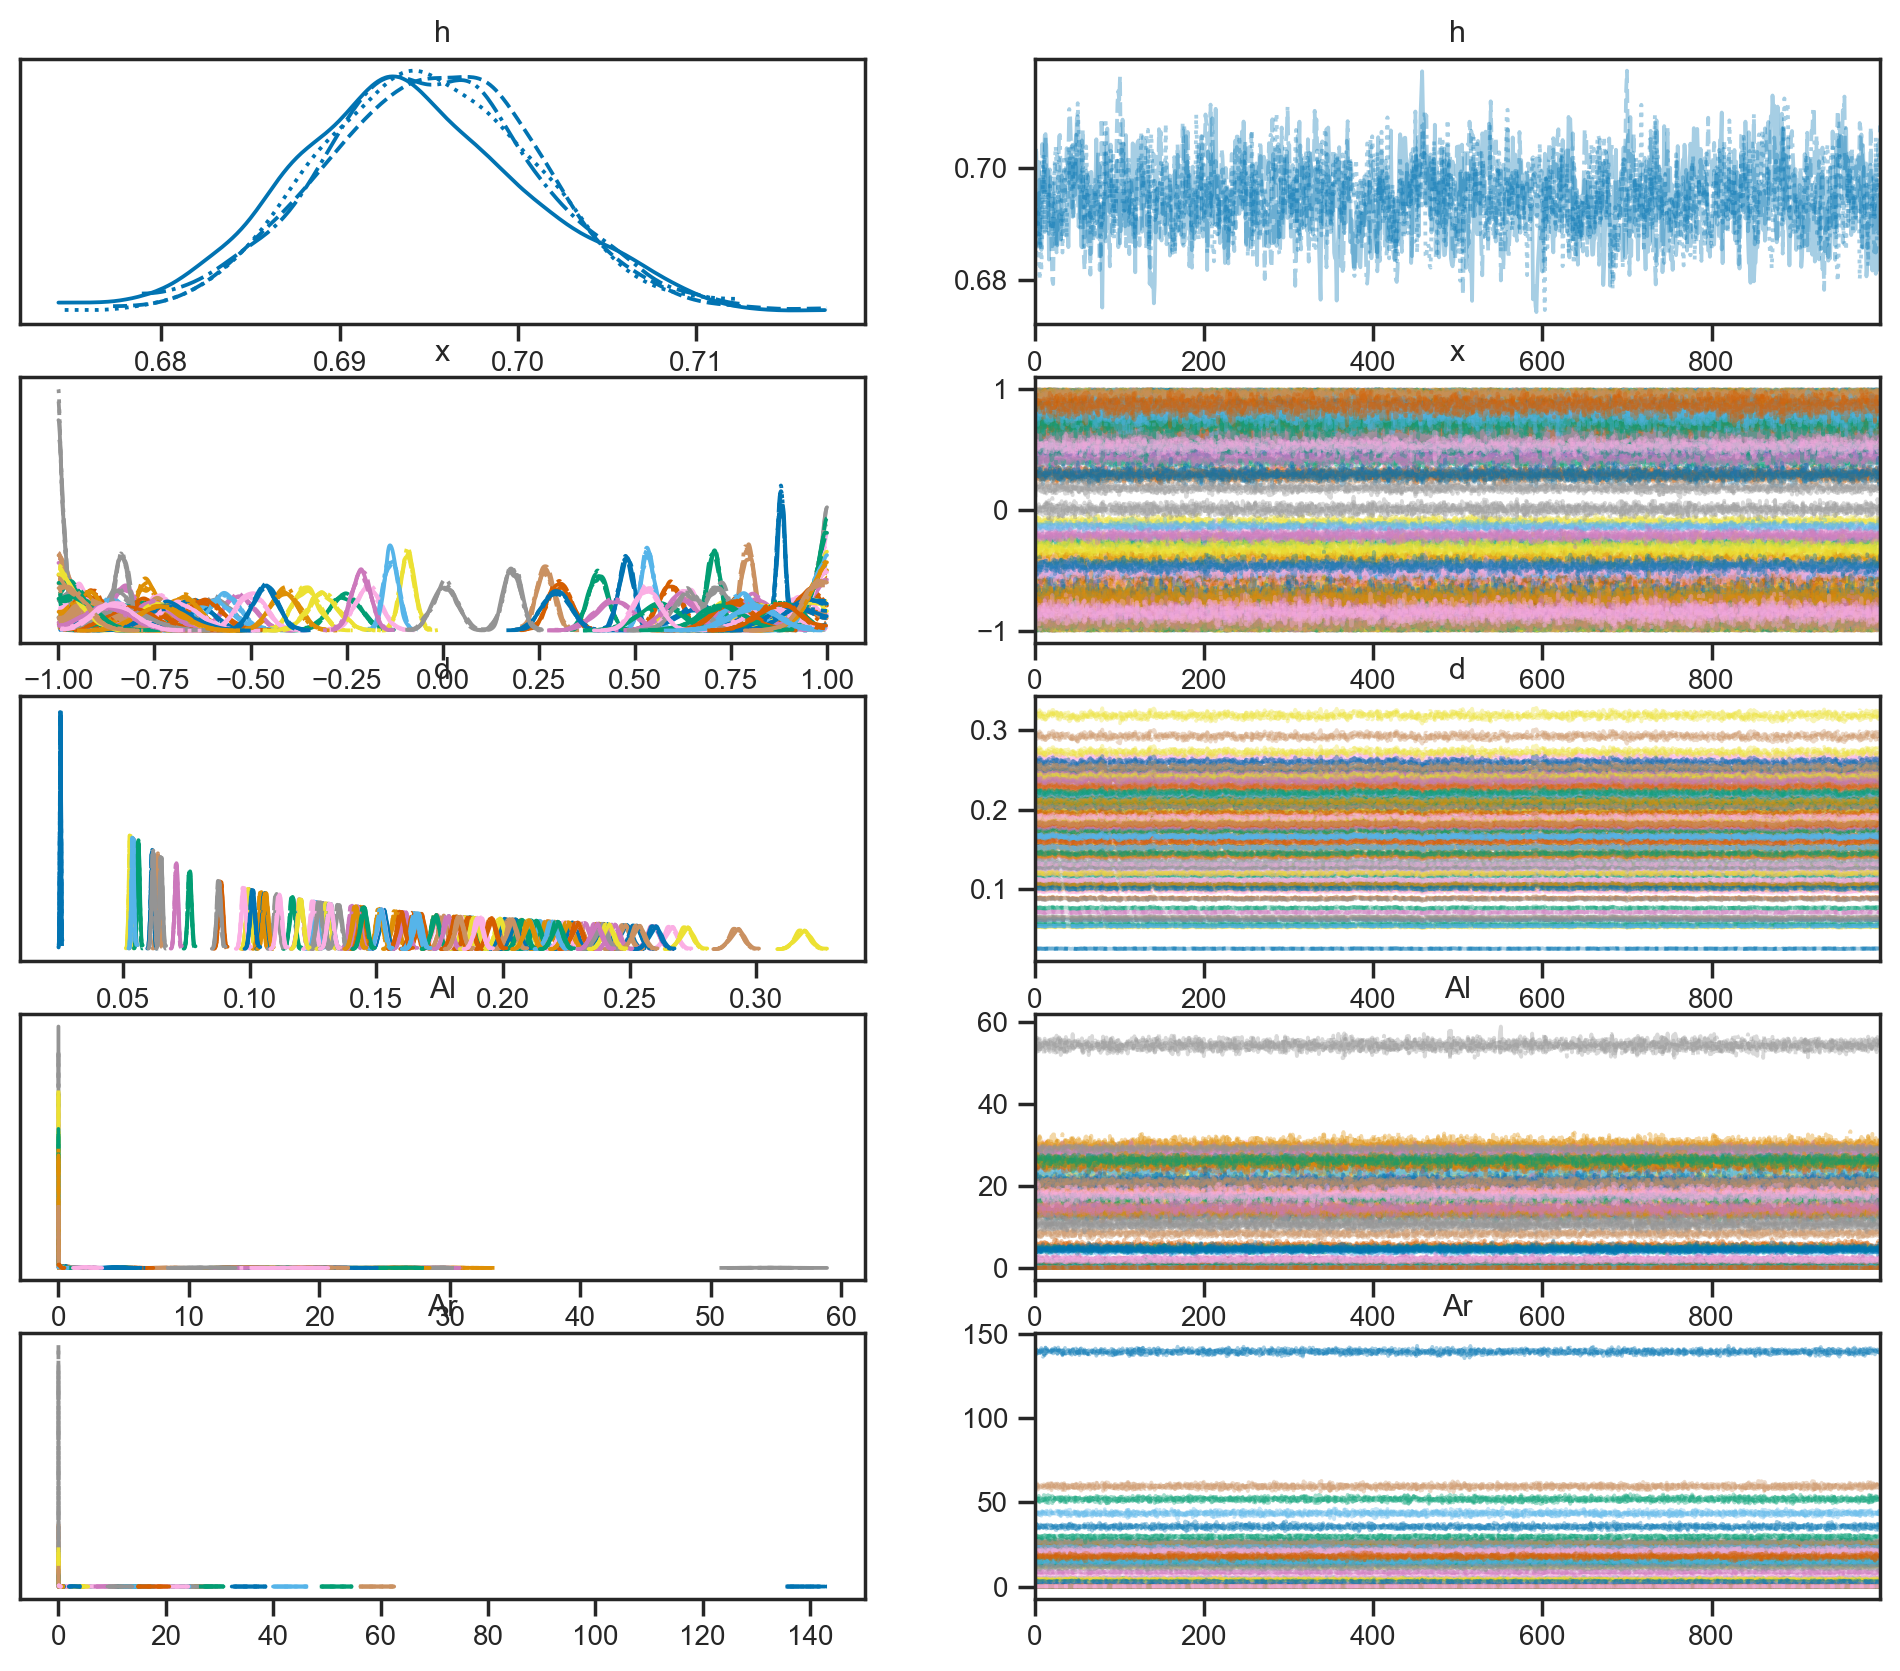

In [12]:
az.plot_trace(trace_gw_only)

Now we will run the model on the *EM selected* events, but without accounting for the different $x$ and $d$ distributions:

In [13]:
model_em_nocorrection = models.make_model(Al[em_detected][:nobs], Ar[em_detected][:nobs], z_true[em_detected][:nobs], x_true, d_true, Ndraw)
with model_em_nocorrection:
    trace_em_nocorrection = pm.sample(tune=2000, draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [14]:
az.summary(trace_em_nocorrection)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
h         0.742  0.007   0.729    0.756      0.000    0.000     861.0   
x[0]     -0.886  0.033  -0.949   -0.825      0.000    0.000    4758.0   
x[1]      0.917  0.036   0.852    0.986      0.001    0.000    3951.0   
x[2]      0.891  0.042   0.812    0.972      0.001    0.000    5788.0   
x[3]      0.790  0.062   0.667    0.902      0.001    0.001    7120.0   
...         ...    ...     ...      ...        ...      ...       ...   
Ar[123]   0.047  0.045   0.000    0.127      0.001    0.000    3888.0   
Ar[124]  23.261  0.863  21.724   24.822      0.010    0.007    6116.0   
Ar[125]   0.091  0.066   0.000    0.205      0.001    0.001    4362.0   
Ar[126]   0.052  0.054   0.000    0.149      0.001    0.000    5007.0   
Ar[127]  29.530  1.020  27.647   31.501      0.012    0.009    7168.0   

         ess_tail  r_hat  
h          1739.0    1.0  
x[0]       2760.0    1.0  
x[1]       2397.0    1.0  
x[2]       2917.0    1.0  
x[3]       3349.0    1.0  
...           ...    ...  
Ar[123]    1989.0    1.0  
Ar[124]    3432.0    1.0  
Ar[125]    2630.0    1.0  
Ar[126]    2849.0    1.0  
Ar[127]    3423.0    1.0  

[513 rows x 9 columns]

array([[<Axes: title={'center': 'h'}>, <Axes: title={'center': 'h'}>],
       [<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>],
       [<Axes: title={'center': 'd'}>, <Axes: title={'center': 'd'}>],
       [<Axes: title={'center': 'Al'}>, <Axes: title={'center': 'Al'}>],
       [<Axes: title={'center': 'Ar'}>, <Axes: title={'center': 'Ar'}>]],
      dtype=object)

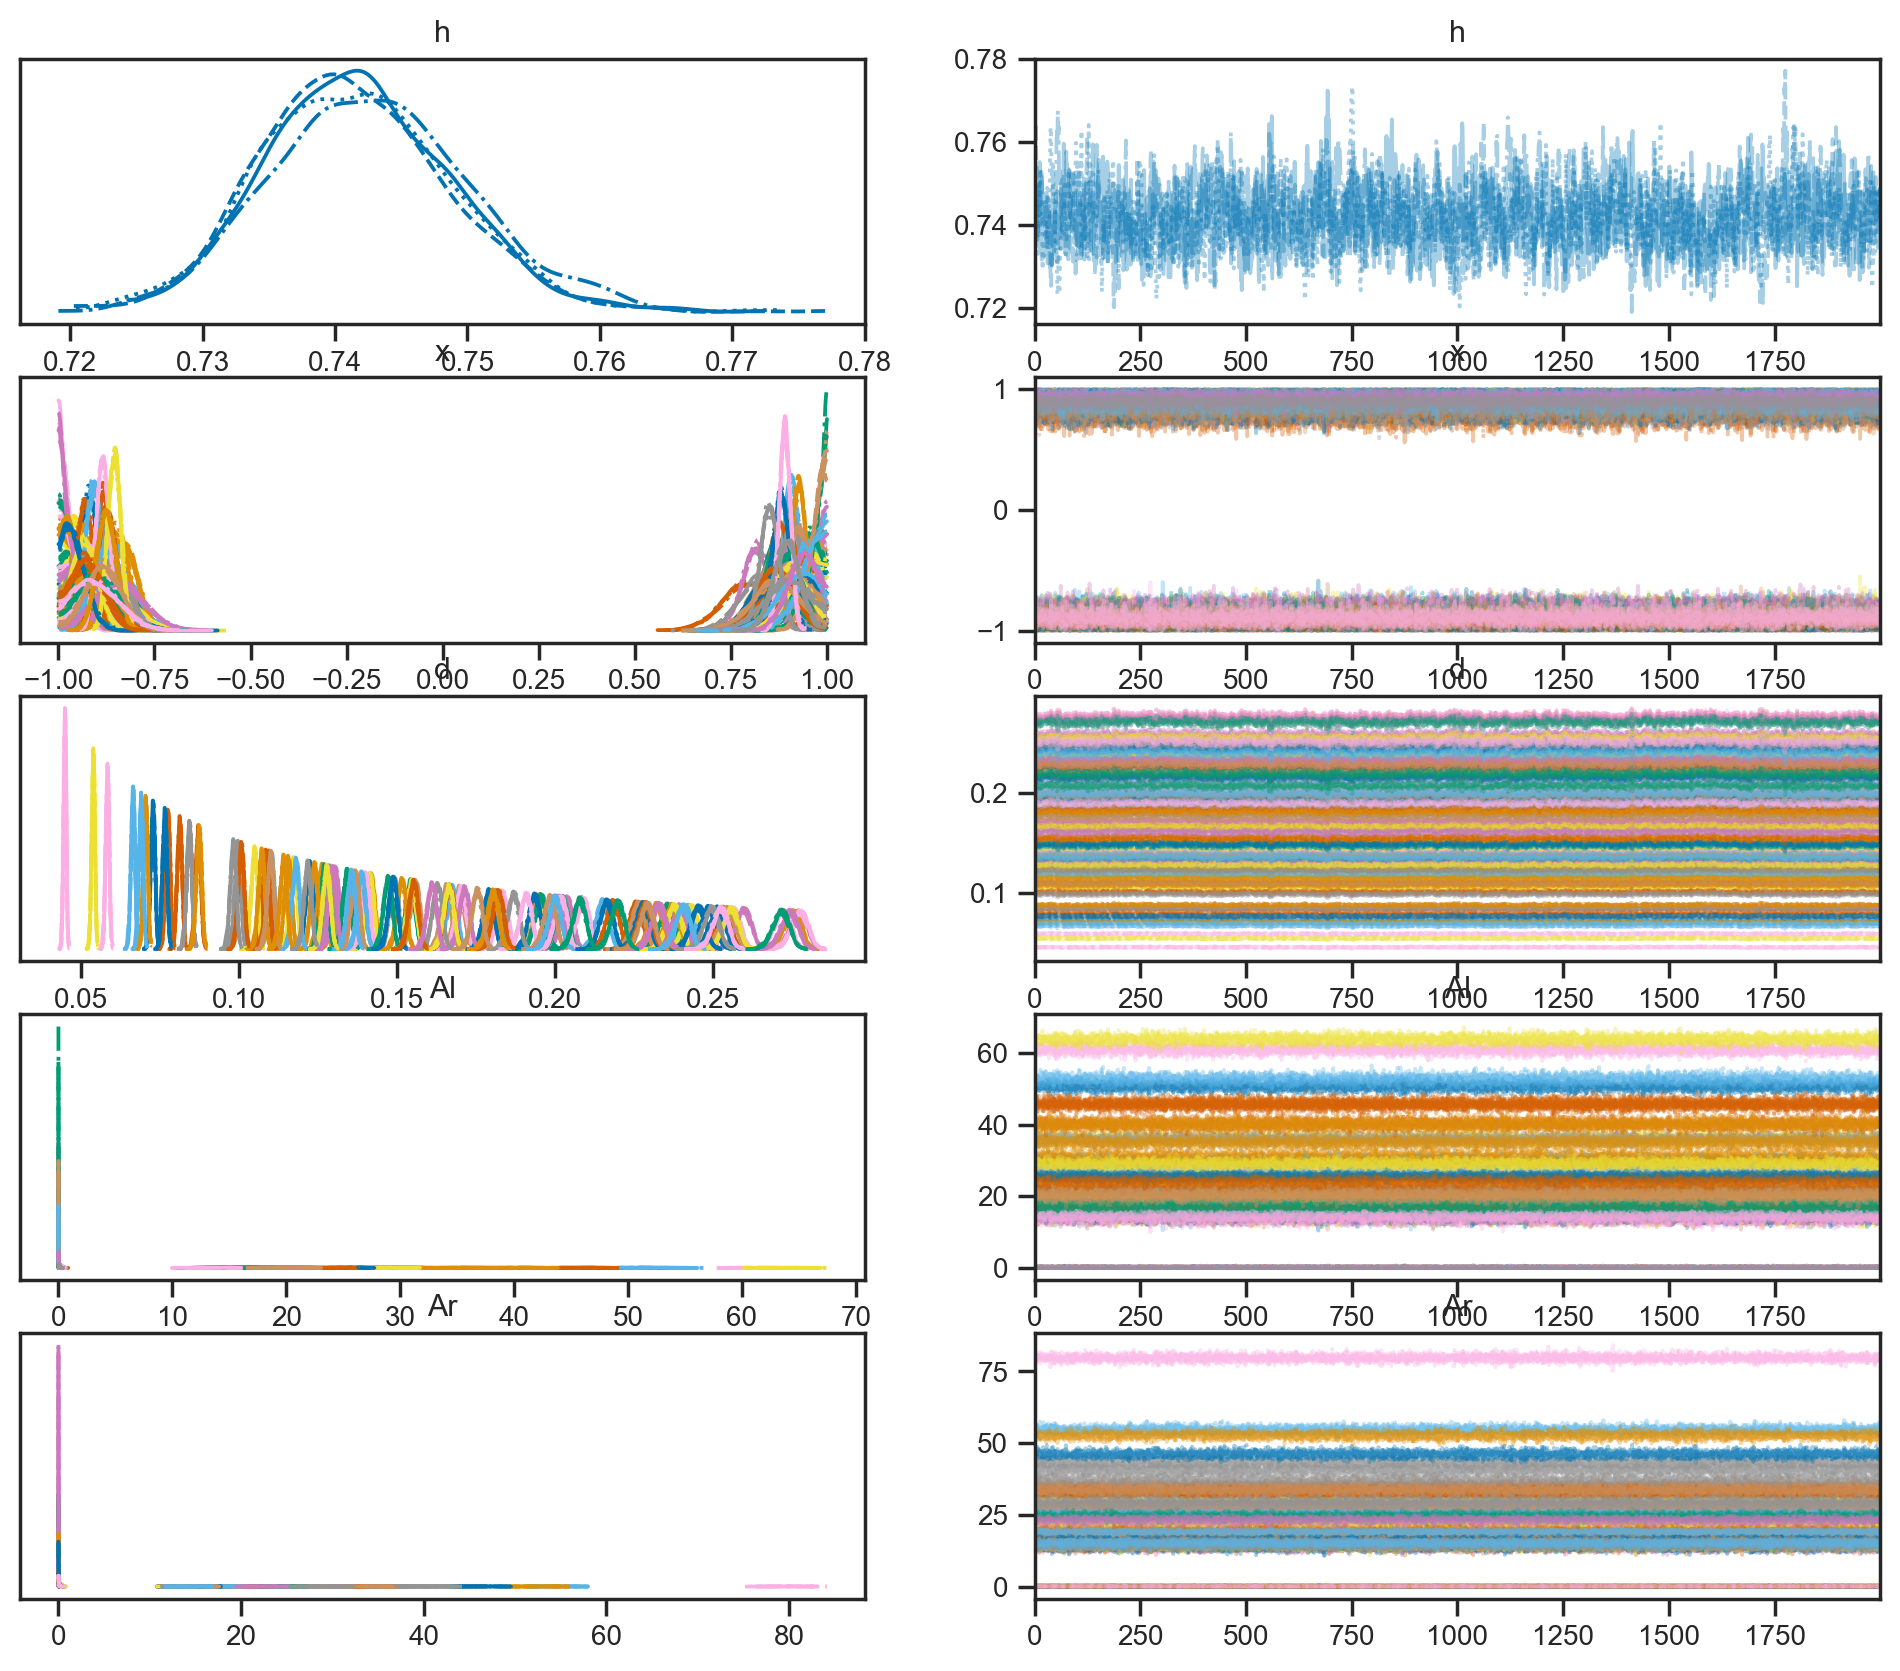

In [15]:
az.plot_trace(trace_em_nocorrection)

So, without accounting for EM selection effects, we see that we will be strongly biased in our measurement:

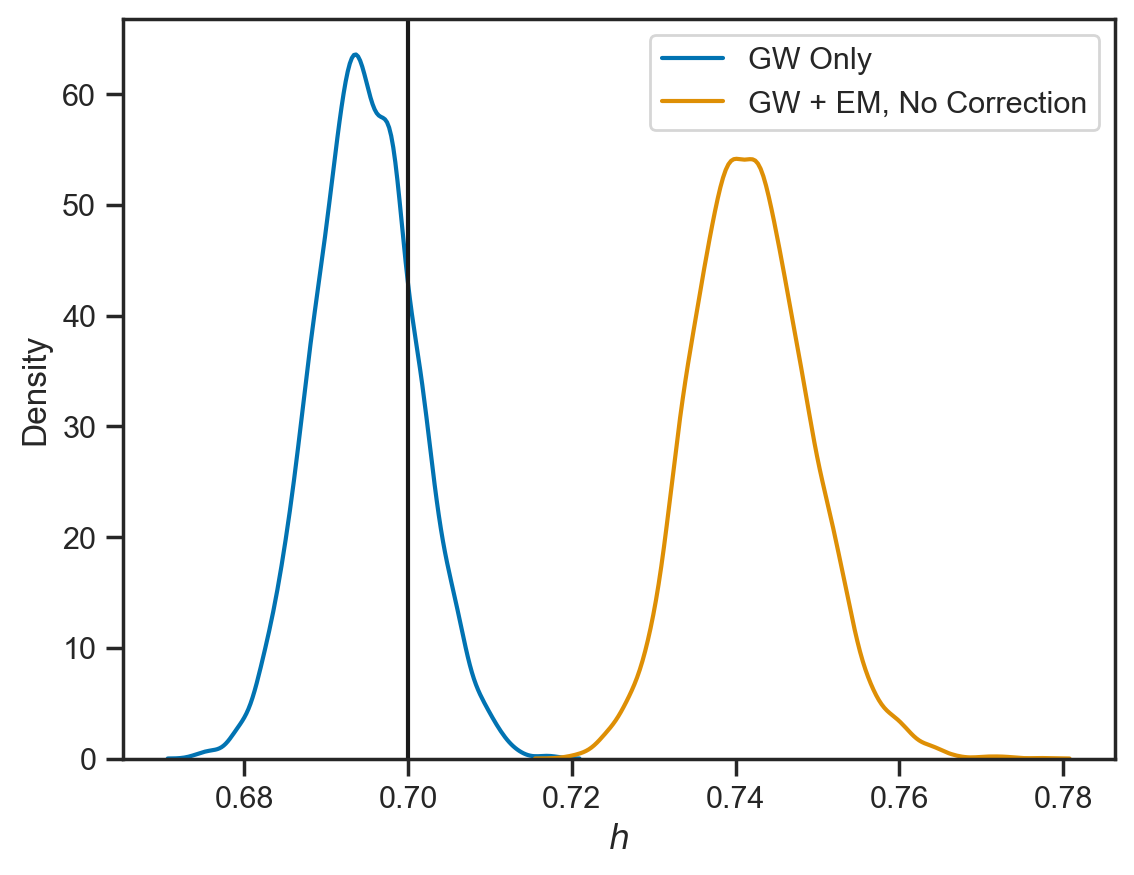

In [16]:
sns.kdeplot(trace_gw_only.posterior.h.values.flatten(), label='GW Only')
sns.kdeplot(trace_em_nocorrection.posterior.h.values.flatten(), label='GW + EM, No Correction')
plt.axvline(0.7, color='k')
plt.xlabel(r'$h$')
plt.legend()

Now we make a model with the EM correction.  In order to make the selection function calculation more efficient, we will restrict to injections with $\left| x \right| > 0.75$ (since our draw is flat in $x$, this does not alter the *shape* of the draw density, just the normalization, which we ignore anyway---but would need to account for if we wanted to estimate the joint GRB/GW rate properly).

In [23]:
sel_thin = 4
model_em_correction = models.make_model(Al[em_detected][:nobs], Ar[em_detected][:nobs], z_true[em_detected][:nobs], x_true[::sel_thin], d_true[::sel_thin], Ndraw/sel_thin, correct_em=True, log_L0_guess = -2*np.log(np.median(trace_em_nocorrection.posterior.d.values.flatten())))
with model_em_correction:
    trace_em_correction = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, x, fl, log_L0, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 200 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree dep

In [28]:
az.summary(trace_em_correction, var_names=['fl', 'log_L0', 'sigma', 'h'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
fl[1]  -0.032  0.398  -0.710    0.778      0.016    0.011     648.0    1124.0   
fl[2]   2.266  0.457   1.414    3.144      0.017    0.012     671.0     903.0   
fl[3]   0.055  0.503  -1.002    0.911      0.018    0.013     802.0    1062.0   
fl[4]   2.918  0.522   1.924    3.878      0.021    0.015     604.0    1656.0   
log_L0  6.929  0.421   6.187    7.748      0.017    0.012     580.0    1885.0   
sigma   0.369  0.195   0.109    0.716      0.008    0.005     440.0     215.0   
h       0.698  0.004   0.690    0.707      0.000    0.000     319.0    1006.0   

        r_hat  
fl[1]    1.01  
fl[2]    1.01  
fl[3]    1.01  
fl[4]    1.00  
log_L0   1.01  
sigma    1.01  
h        1.02

array([[<Axes: title={'center': 'fl'}>, <Axes: title={'center': 'fl'}>],
       [<Axes: title={'center': 'log_L0'}>,
        <Axes: title={'center': 'log_L0'}>],
       [<Axes: title={'center': 'h'}>, <Axes: title={'center': 'h'}>],
       [<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'd'}>, <Axes: title={'center': 'd'}>],
       [<Axes: title={'center': 'inc_dependent_flux_factor'}>,
        <Axes: title={'center': 'inc_dependent_flux_factor'}>],
       [<Axes: title={'center': 'Al'}>, <Axes: title={'center': 'Al'}>],
       [<Axes: title={'center': 'Ar'}>, <Axes: title={'center': 'Ar'}>],
       [<Axes: title={'center': 'Neff'}>,
        <Axes: title={'center': 'Neff'}>]], dtype=object)

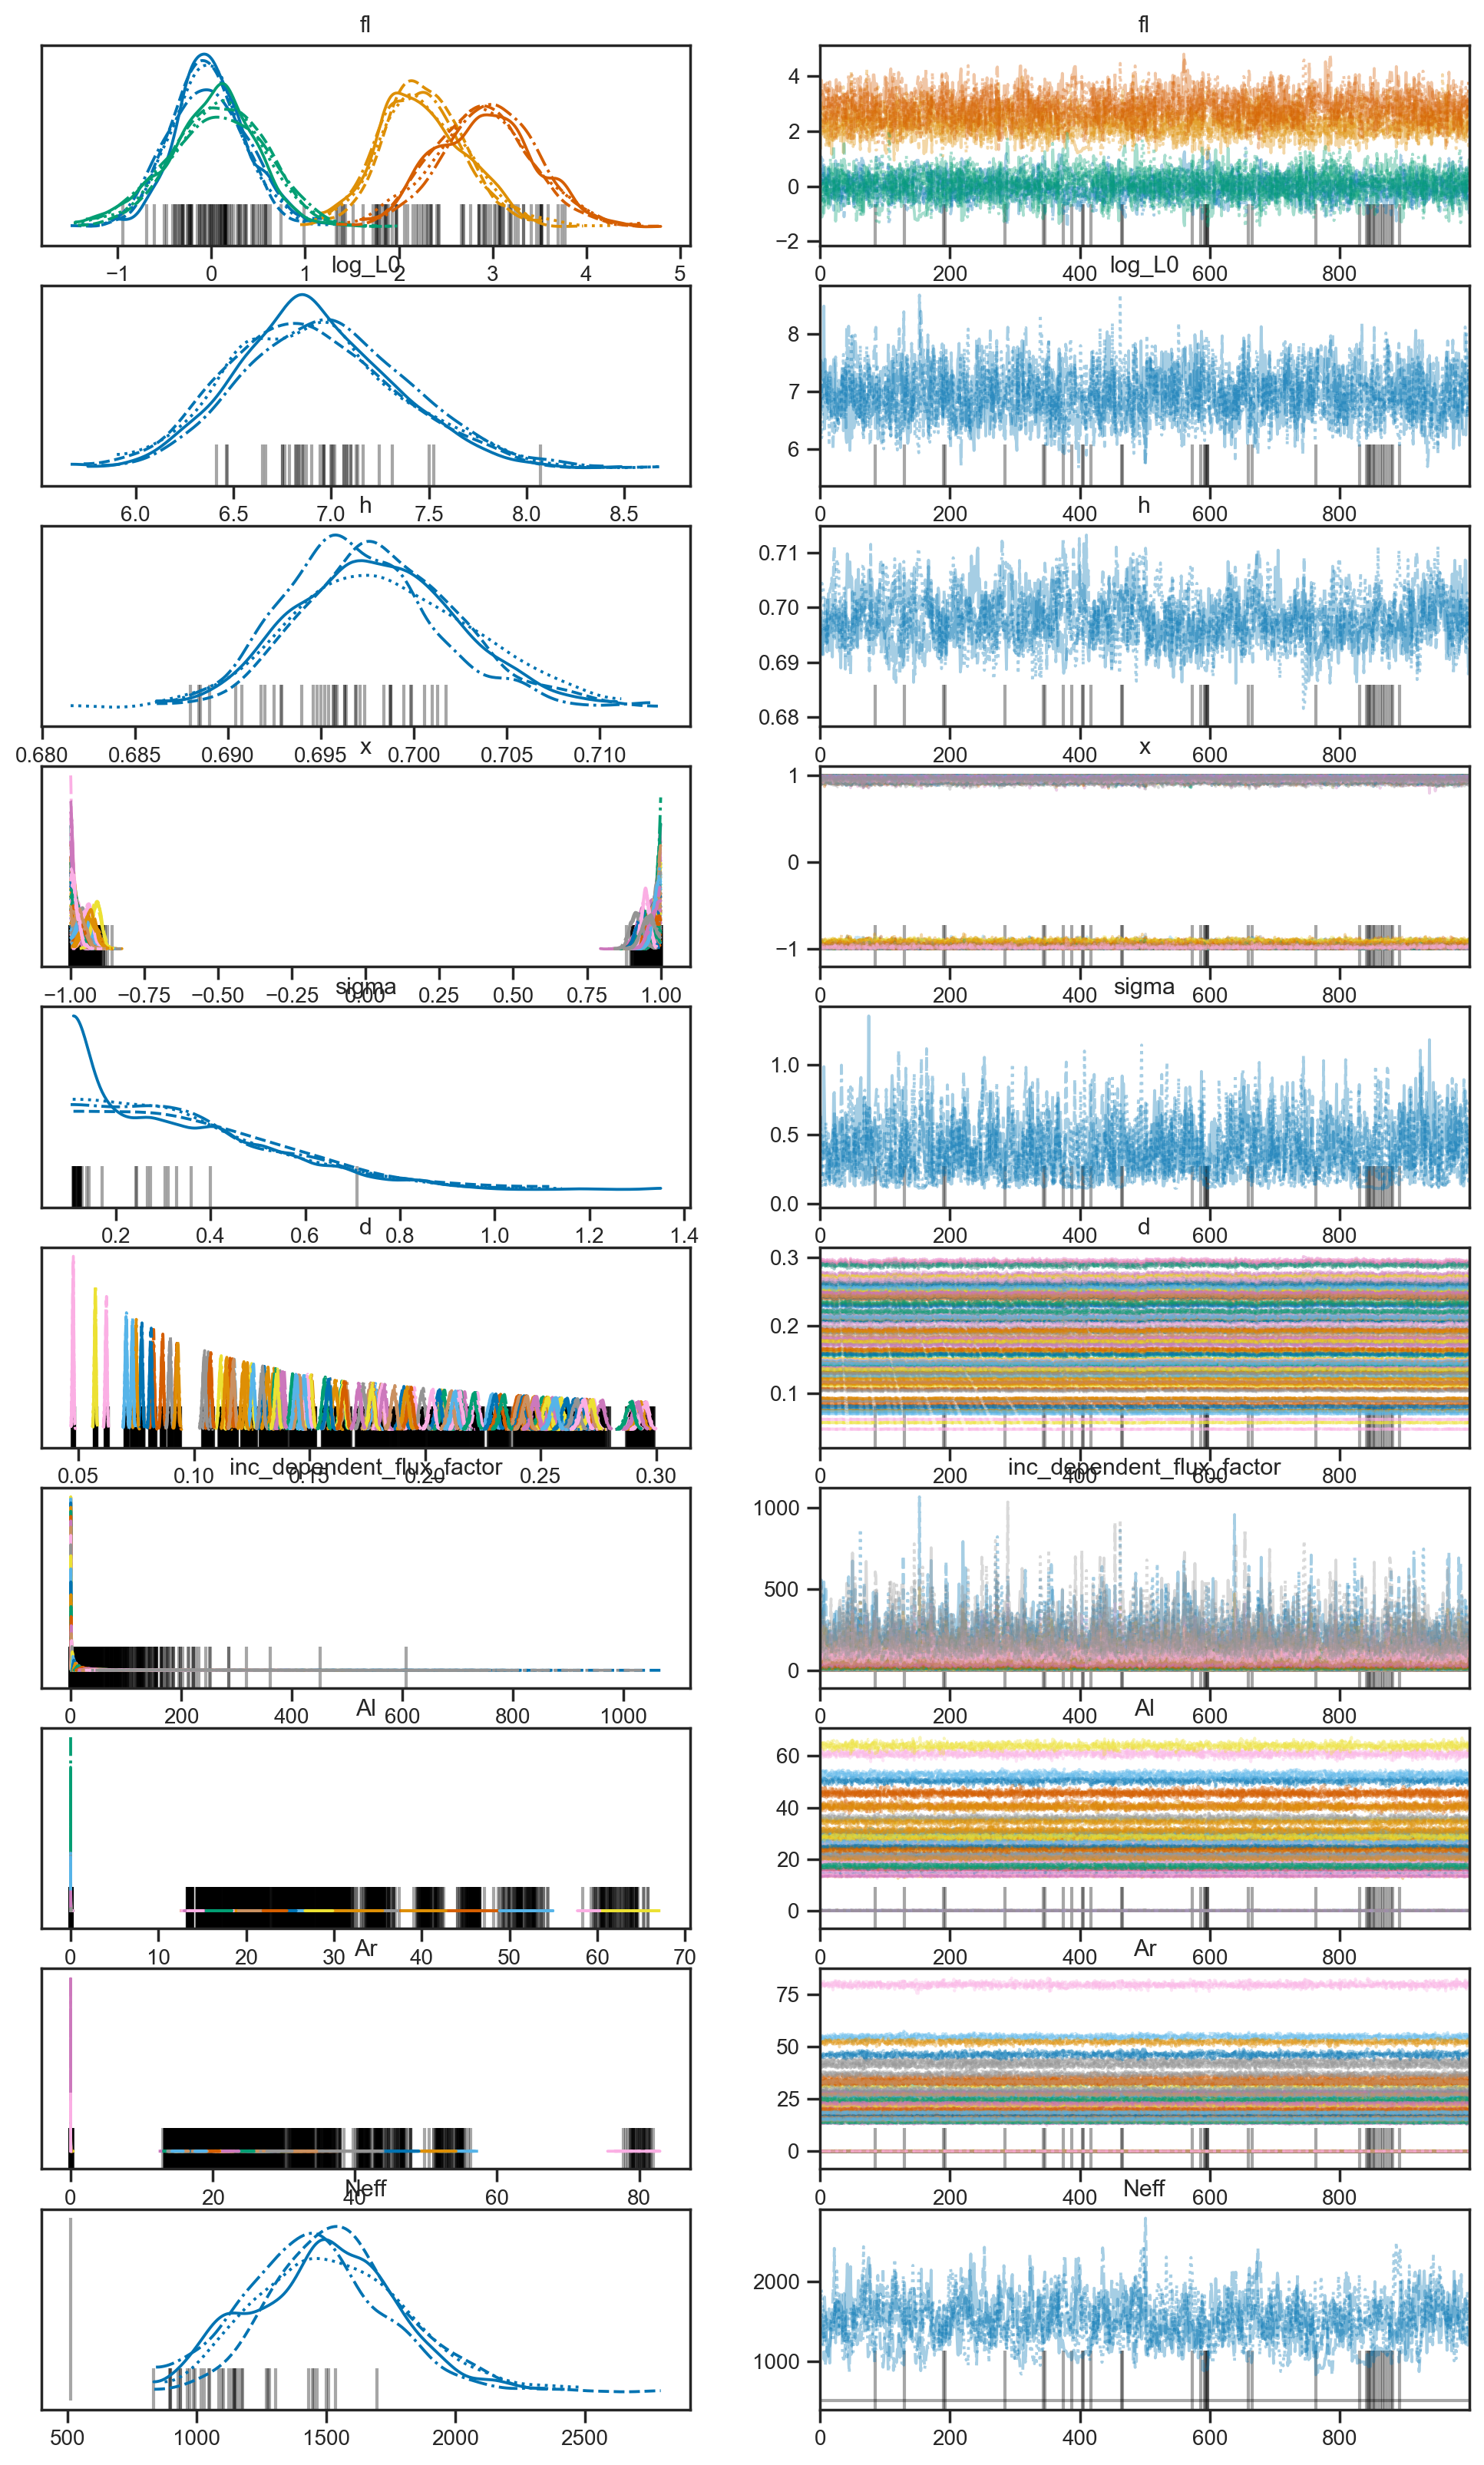

In [24]:
az.plot_trace(trace_em_correction, lines=[('Neff', {}, 4*nobs)])

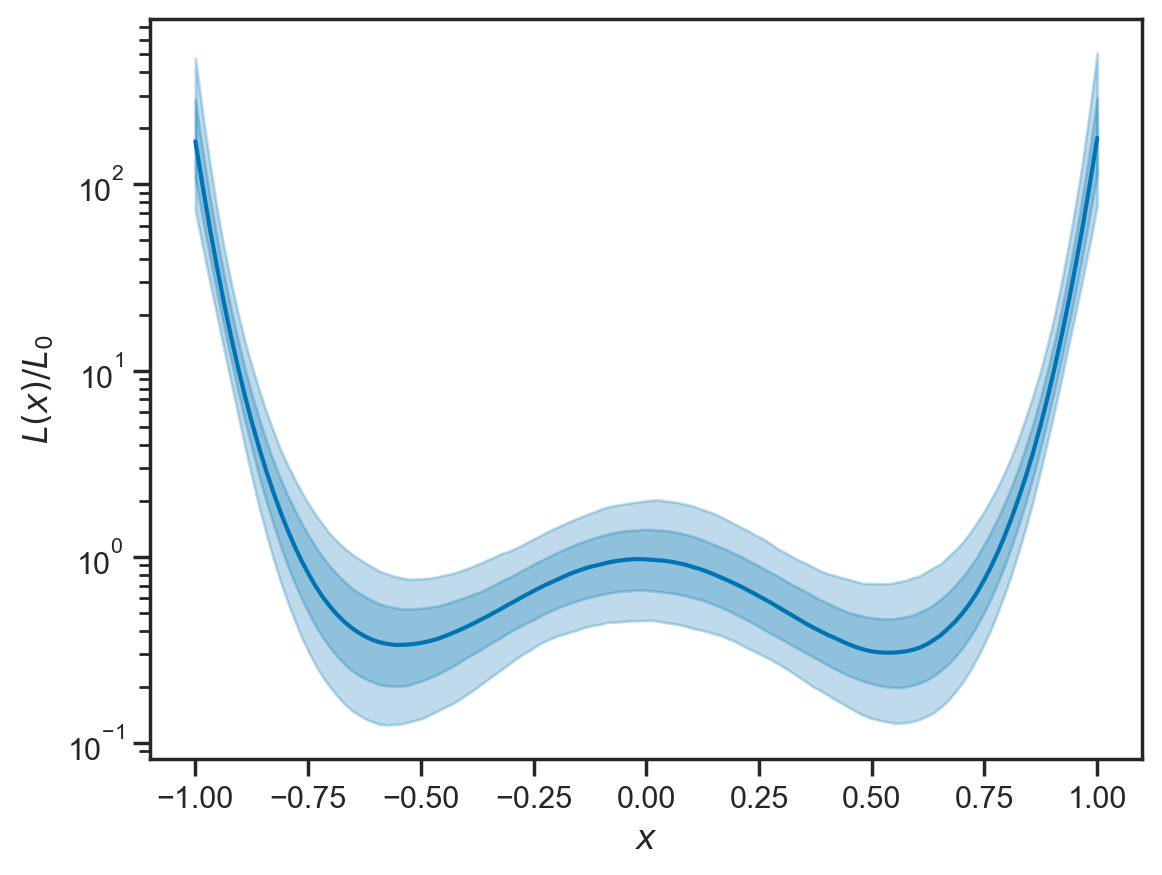

In [25]:
l, = plt.plot(trace_em_correction.posterior.xinterp, trace_em_correction.posterior.inc_dependent_flux_factor.median(dim=('chain', 'draw')))
plt.fill_between(trace_em_correction.posterior.xinterp, trace_em_correction.posterior.inc_dependent_flux_factor.quantile(0.84, dim=('chain', 'draw')), trace_em_correction.posterior.inc_dependent_flux_factor.quantile(0.16, dim=('chain', 'draw')), color=l.get_color(), alpha=0.25)
plt.fill_between(trace_em_correction.posterior.xinterp, trace_em_correction.posterior.inc_dependent_flux_factor.quantile(0.975, dim=('chain', 'draw')), trace_em_correction.posterior.inc_dependent_flux_factor.quantile(0.025, dim=('chain', 'draw')), color=l.get_color(), alpha=0.25)
plt.xlabel(r'$x$')
plt.ylabel(r'$L(x)/L_0$')
plt.yscale('log')

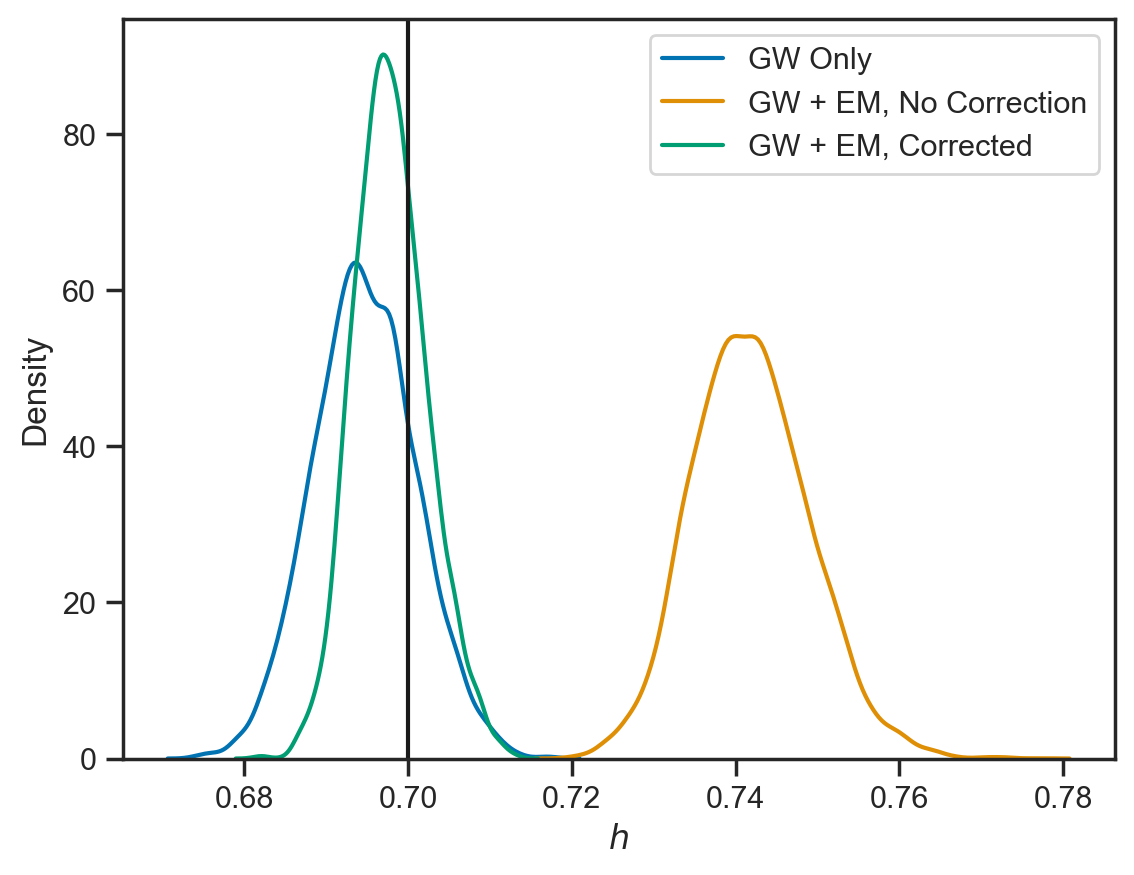

In [26]:
sns.kdeplot(trace_gw_only.posterior.h.values.flatten(), label='GW Only')
sns.kdeplot(trace_em_nocorrection.posterior.h.values.flatten(), label='GW + EM, No Correction')
sns.kdeplot(trace_em_correction.posterior.h.values.flatten(), label='GW + EM, Corrected')
plt.axvline(0.7, color='k')
plt.xlabel(r'$h$')
plt.legend()